In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

## 1: Load the houseprices data

In [4]:
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [5]:
import warnings
warnings.filterwarnings(action="ignore")

In [6]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [7]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

In [8]:
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

In [9]:
# no need for an open connection, as we're only doing a single query
engine.dispose()

In [10]:
# load the dataset
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## 2: Data cleaning, exploratory data analysis, and feature engineering

#Descriptive statistics

In [11]:
# shape
print(houseprices_df.shape)

(1460, 81)


In [12]:
# types
print(houseprices_df.dtypes)

id                 int64
mssubclass         int64
mszoning          object
lotfrontage      float64
lotarea            int64
                  ...   
mosold             int64
yrsold             int64
saletype          object
salecondition     object
saleprice          int64
Length: 81, dtype: object


Some variables are numeric, others are categorical. So not all of the features or variables are of numeric type.

In [13]:
# get numeric data
numeric_data = houseprices_df.select_dtypes(include=np.number)
# print number of numeric data
print(numeric_data.shape[1])

38


So, out of the 81 columns in the dataset, 38 are numeric. The others are categorical.

To make things easier, I will examine the characteristics of the numeric columns. Also, moving forward, I will complete the rest of the modeling by working with numeric colums alone.

In [14]:
# correlation between all of the numeric attributes.
pd.set_option('precision', 2)
print(numeric_data.corr(method='pearson'))

                  id  mssubclass  lotfrontage  lotarea  overallqual  \
id             1.000       0.011       -0.011   -0.033       -0.028   
mssubclass     0.011       1.000       -0.386   -0.140        0.033   
lotfrontage   -0.011      -0.386        1.000    0.426        0.252   
lotarea       -0.033      -0.140        0.426    1.000        0.106   
overallqual   -0.028       0.033        0.252    0.106        1.000   
overallcond    0.013      -0.059       -0.059   -0.006       -0.092   
yearbuilt     -0.013       0.028        0.123    0.014        0.572   
yearremodadd  -0.022       0.041        0.089    0.014        0.551   
masvnrarea    -0.050       0.023        0.193    0.104        0.412   
bsmtfinsf1    -0.005      -0.070        0.234    0.214        0.240   
bsmtfinsf2    -0.006      -0.066        0.050    0.111       -0.059   
bsmtunfsf     -0.008      -0.141        0.133   -0.003        0.308   
totalbsmtsf   -0.015      -0.239        0.392    0.261        0.538   
firstf

In [15]:
# Find attributes with high correlation
corr_matrix = numeric_data.corr().abs()

# the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
# print top 10 highly positively correlated numeric attributes
sol[:10]

garagecars    garagearea     0.882
yearbuilt     garageyrblt    0.826
grlivarea     totrmsabvgrd   0.825
totalbsmtsf   firstflrsf     0.820
overallqual   saleprice      0.791
grlivarea     saleprice      0.709
secondflrsf   grlivarea      0.688
bedroomabvgr  totrmsabvgrd   0.677
bsmtfinsf1    bsmtfullbath   0.649
yearremodadd  garageyrblt    0.642
dtype: float64

In [16]:
# print top 10 highly correlated numeric attributes
sol[-10:]

halfbath       miscval         0.001
lotarea        mosold          0.001
garageyrblt    yrsold          0.001
id             yrsold          0.001
lowqualfinsf   fullbath        0.001
id             openporchsf     0.000
threessnporch  miscval         0.000
totalbsmtsf    bsmthalfbath    0.000
bsmtfullbath   threessnporch   0.000
id             garageyrblt     0.000
dtype: float64

Attributes will typically have a strong correlation when the correlation matrix returns > 0.70 or < -0.70.

Among the numeric attributes, the following pairs are strongly correlated:

(garagecars, garagearea) --> 0.882
(yearbuilt, garageyrblt) --> 0.826
(grlivarea, totrmsabvgrd) --> 0.825
(totalbsmtsf, firstflrsf) --> 0.820
(overallqual, saleprice) --> 0.791
(grlivarea, saleprice) --> 0.709
However, we do not have any strong negative correlated columns.

#Data Visualizations

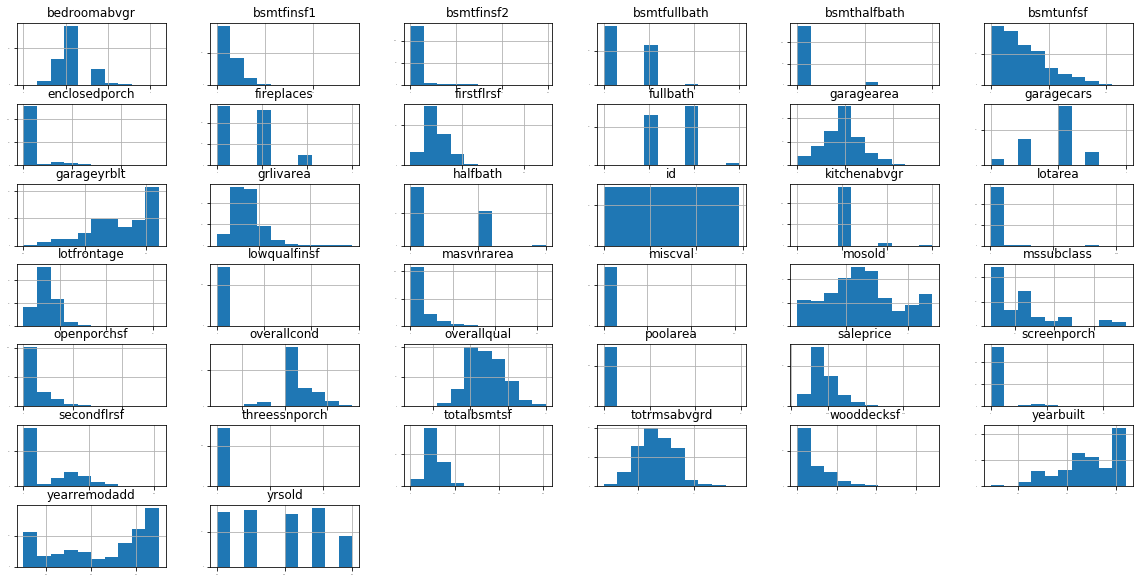

In [17]:
# plot histograms
numeric_data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(20,10))
plt.show()

Here, you have a visual description of the distribution shape for each column (or feature). We can see that some attributes have an Exponential distribution like bsmtunfsf, bsmtfinsf1 and garageyrblt. And others have a bimodal distribution such as saleprice.

Let's have even more intuition into the shape of the distribution by plotting density plots.

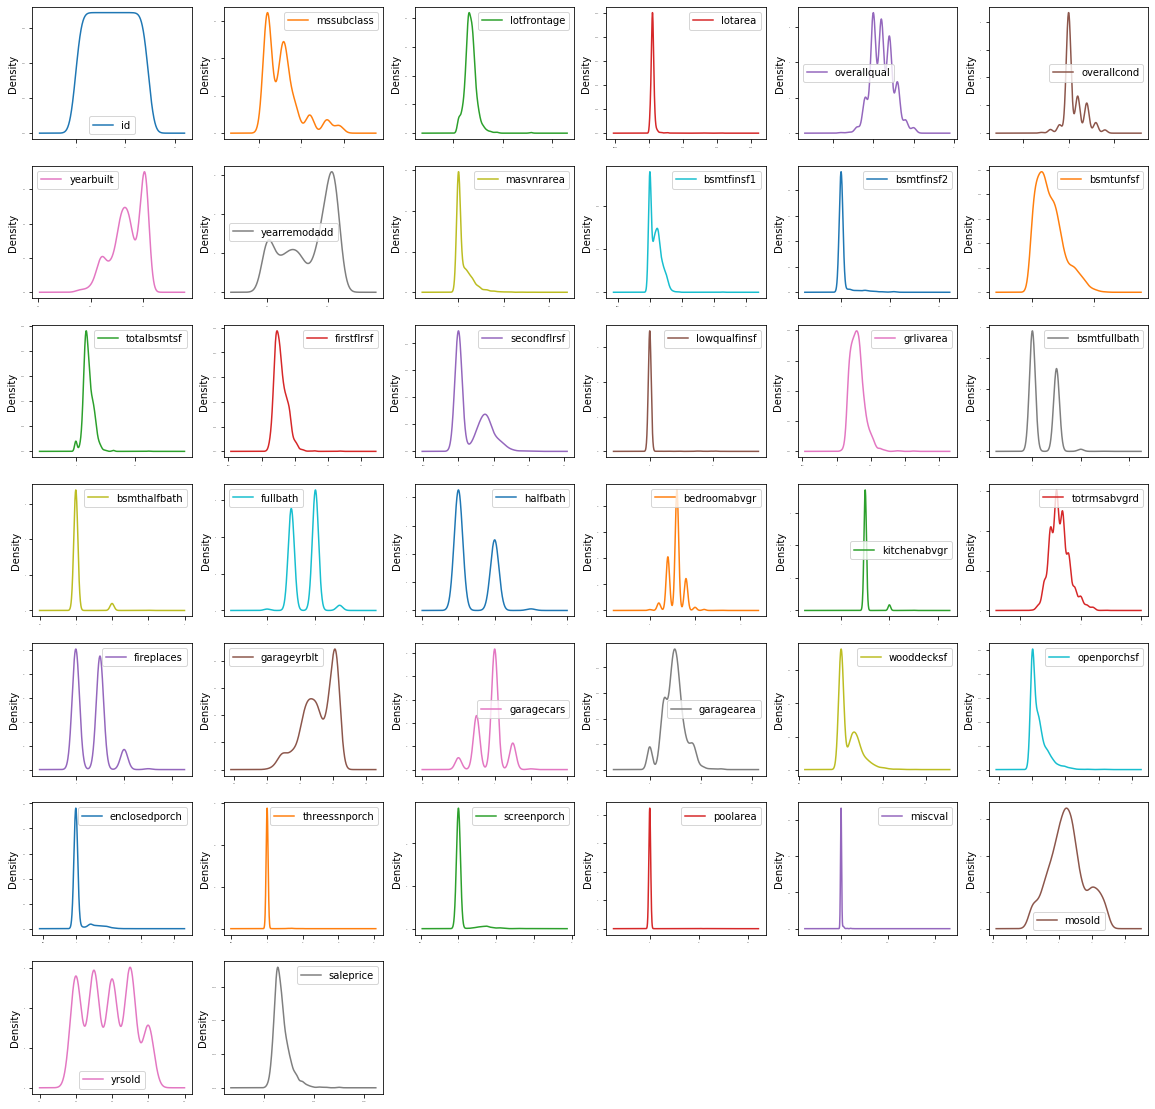

In [18]:
# plot density
numeric_data.plot(kind='density', subplots=True, layout=(7,6), sharex=False, fontsize=1, figsize=(20,20))
plt.show()

The next thing is that we want to have a visual idea of the outlier (if any) in each of the columns (or features). So we will use a box and whisker plot.

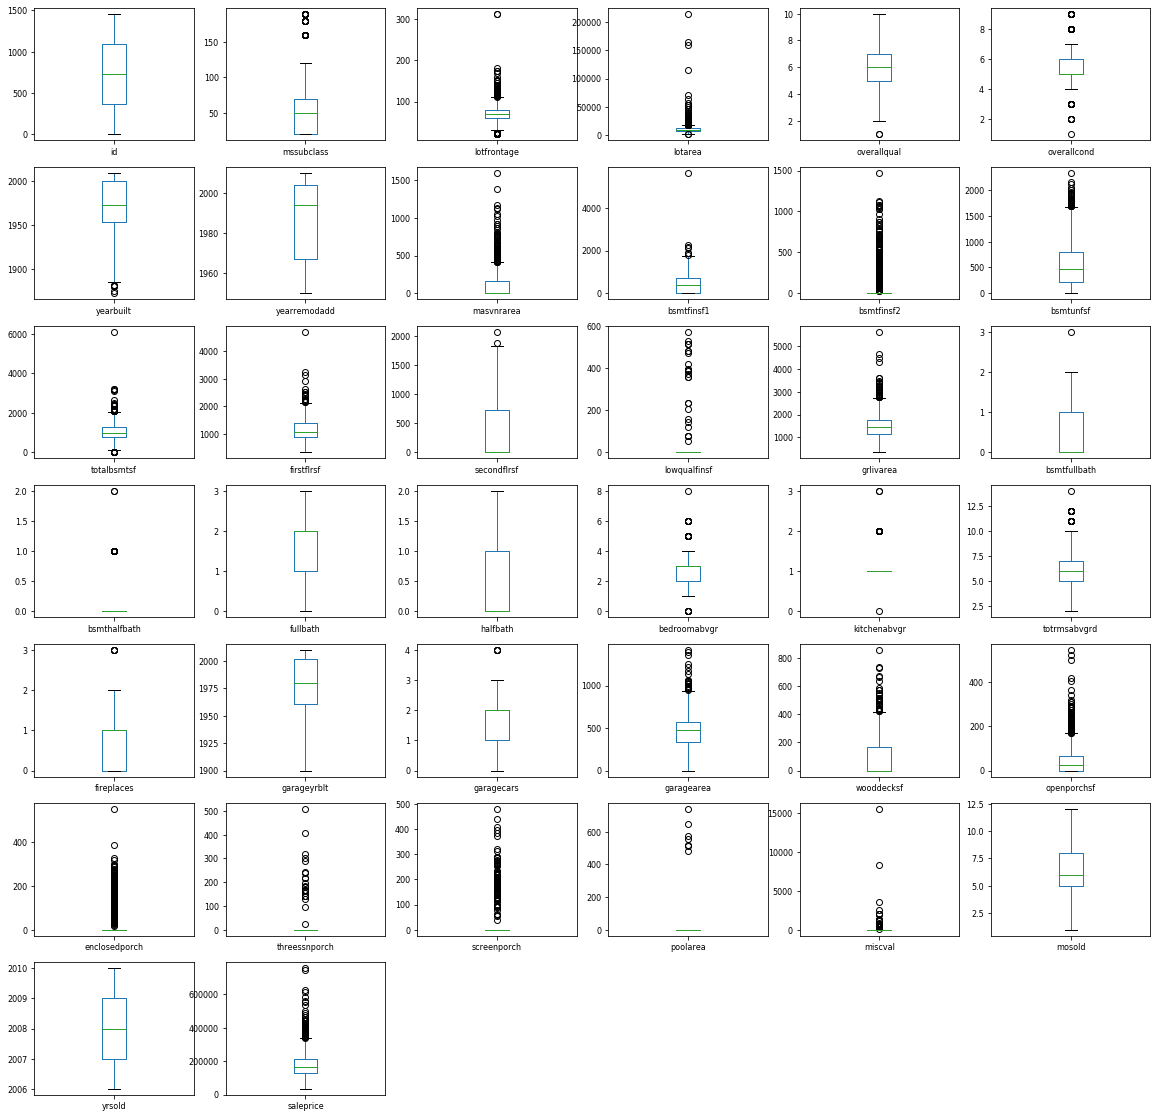

In [38]:
# plot box and whisker plots
numeric_data.plot(kind='box', subplots=True, layout=(7,6), sharex=False, fontsize=8, figsize=(20,20))
plt.show()

#3: Split your data into train and test sets

#Remember, that the target faeature is saleprice. Others are predictive features.

In [20]:
# remove missing values
data = numeric_data.dropna()

In [21]:
# separate the design and target features
X = data[data.columns.difference(['saleprice'])]
y = data[['saleprice']]

In [22]:
print('Shape of features:', X.shape)
print('Shape of target:', y.shape)

Shape of features: (1121, 37)
Shape of target: (1121, 1)


In [23]:
# split the dataset into train set (80%) and test set (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [24]:
print('Train X-shape:', X_train.shape)
print('Train y-shape:', y_train.shape)
print('Test X-shape:', X_test.shape)
print('Test X-shape:', y_test.shape)

Train X-shape: (896, 37)
Train y-shape: (896, 1)
Test X-shape: (225, 37)
Test X-shape: (225, 1)


## 4: Build several linear regression models

In [25]:
# standardize the features
scaler = StandardScaler().fit(X_train)
standardize_X_train = scaler.transform(X_train)

In [26]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('Ridge', Ridge()))

In [27]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=3, shuffle=True)
  cv_results = cross_val_score(model, standardize_X_train, y_train, cv=kfold)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.629228 (0.216420)
LASSO: 0.638056 (0.200477)
EN: 0.767213 (0.087252)
Ridge: 0.693562 (0.112013)


From the results, Ridge Regression (LR) has the lowest mean error, 0.63. It is followed by Elastic Net with a mean error of 0.66.

## 5: Evaluate your best model on the test set

In [43]:
# run best model - Ridge Regression
# model = LinearRegression(normalize = True)
model = Ridge(normalize = True)
model.fit(standardize_X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [44]:
# transform the test dataset
standardize_X_test = scaler.transform(X_test)

In [45]:
# make predictions on the test data
predictions = model.predict(standardize_X_test)

In [46]:
# print rmse on test sset
print(rmse(y_test, predictions))

[33486.4658721]


## 6: The factors to effect the data 

In [48]:
np.random.seed(456)

# X is the feature.
X = pd.DataFrame(25 - np.arange(1,51)) 

# We define Y as a quadratic function of X.
# We also add a little bit of noise to Y.
Y = X + X**2 +  pd.DataFrame(np.random.normal(0,100,50))

# This is the model with linear feature
lrm_underfit = LinearRegression().fit(X, Y)
preds_underfit = lrm_underfit.predict(X)

# This is the model with quadratic feature
X_correct = pd.concat([X, X**2], axis=1)
lrm_correct = LinearRegression().fit(X_correct, Y)
preds_correct = lrm_correct.predict(X_correct)

# This is the model with up to 10th order polynomial of the feature
X_overfit = pd.concat([X**i for i in range(1,11)], axis=1)
lrm_overfit = LinearRegression().fit(X_overfit, Y)
preds_overfit = lrm_overfit.predict(X_overfit)

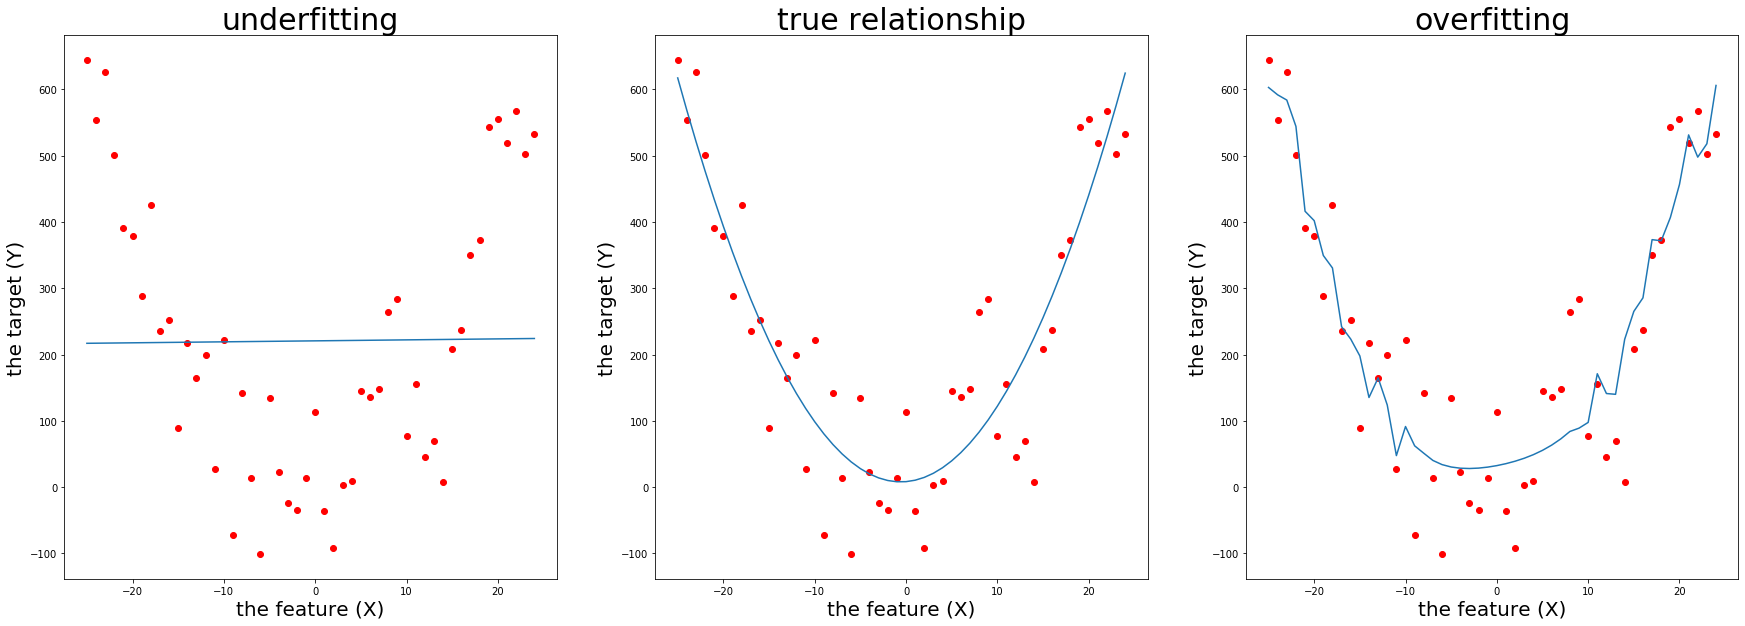

In [49]:
# We plot the predictions of the three models.
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_underfit)
plt.title("underfitting", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.subplot(1,3,2)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_correct)
plt.title("true relationship", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.subplot(1,3,3)
plt.scatter(X, Y, color="red")
plt.plot(X, preds_overfit)
plt.title("overfitting", fontsize=30)
plt.xlabel("the feature (X)", fontsize=20)
plt.ylabel("the target (Y)", fontsize=20)

plt.show()

In [52]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**37) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.012598811730965885
Mean absolute error of the prediction is: 62573.571562500016
Mean squared error of the prediction is: [6.89618508e+09]
Root mean squared error of the prediction is: [83043.27231084]
Mean absolute percentage error of the prediction is: saleprice   41.492
dtype: float64


In [53]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.012598811730965885
Mean absolute error of the prediction is: 62573.571562500016
Mean squared error of the prediction is: [6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89

ValueError: Unable to coerce to Series, length must be 1: given 225

In [51]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.012598811730965885
Mean absolute error of the prediction is: 62573.571562500016
Mean squared error of the prediction is: [6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89618508e+09 6.89618508e+09 6.89618508e+09
 6.89618508e+09 6.89

ValueError: Unable to coerce to Series, length must be 1: given 225

# Conclusion
The factors effect the data are mssubclass,lotfrontage,lotarea,overallqual, overallcond,yearbuilt,yearremodadd,       masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath       bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,         wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice.           
